# Stacked Denoising AutoEncoder

1. Input Layer : Energy, Contrast, Entropy, Homogeneity, SumAverage, Dissimilarity, AutoCorrelation, Skewness, Kurtosis, Average HU Value
2. Feature 1 : 7
3. Feature 2 : 3
4. Softmax : 2
5. Learning rate : .1 ~ .01
6. Noise factor : 10% on input vector
7. Activation function : sigmoid
8. Cost function : negative log-likelihood

## Three models
1. Feature Extraction : Input -> HL1 -> HL2 -> Decoder -> Weight update
2. Predict Features : Input -> HL1 -> HL2 -> Output
3. Classification : Input of 3 -> HL1 -> HL2 -> Classifier -> Output

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers, regularizers
from keras.callbacks import TensorBoard
from keras.utils import to_categorical

Using TensorFlow backend.


In [33]:
# Preparing dataset - total 1596 images : 649 nodules + 947 non-nodules
df = pd.read_csv('./Datas/nodules_labeled_normed.csv', index_col=0)
# select seed to randomize - [0, 3136, 8405, 4242, 5293]
np.random.seed(3136)

# Resampling technique for solving Class Imbalance
# Random over-sampling : nodules 649 -> 947
nodule_os_idx = np.random.choice(649, 947-649)
df_nodule_os = df.loc[nodule_os_idx]

df_os = pd.concat([df, df_nodule_os])
df_os.sort_values(["Label"], ascending=[False], inplace=True)
df_os.reset_index(drop=True, inplace=True)
df_os.drop(["Energy","Homogeneity"], axis=1, inplace=True)
print(df_os)

      Contrast  Dissimilarity   Entropy  SumAverage  AutoCorrelation  \
0     0.060793       0.191241  0.508526    0.835470         0.747732   
1     0.078852       0.185523  0.771363    0.424021         0.387763   
2     0.166583       0.338598  0.671784    0.514270         0.369265   
3     0.134599       0.289457  0.800151    0.421111         0.314318   
4     0.163204       0.316215  0.858170    0.362923         0.275476   
5     0.159482       0.294970  0.833486    0.319728         0.263842   
6     0.142493       0.271786  0.835539    0.320574         0.268154   
7     0.162361       0.315648  0.821376    0.364281         0.294706   
8     0.079082       0.199192  0.815874    0.236465         0.160414   
9     0.024976       0.094667  0.810382    0.103185         0.058975   
10    0.218712       0.360935  0.656305    0.321504         0.271266   
11    0.215487       0.407549  0.529382    0.592759         0.471366   
12    0.131281       0.300418  0.667384    0.566679         0.45

In [34]:
# Divide training and test datasets - test datasets : 15 nodules, 15 non-nodules
nodule_rand_idx = np.random.choice(947, 15)
nonnodule_rand_idx = np.random.choice(947, 15)

nodule_test = df_os.loc[nodule_rand_idx]
nonnodule_test = df_os.loc[nonnodule_rand_idx + 946]

# Delete the test datasets from dataframe
df_t1 = df_os.drop(nodule_rand_idx, axis=0)
df_train = df_t1.drop(nonnodule_rand_idx + 946, axis=0)
df_test = pd.concat([nodule_test, nonnodule_test])

In [36]:
# Slice the inputs and labels
# iloc : use integer index for slice
# loc : use label for slice
cols = df_os.shape[1] - 1
x_train = df_train.iloc[:, :cols] 
y_train_classifier = df_train.iloc[:, cols]
y_labels_train = to_categorical(y_train_classifier)

x_test_classifier = df_test.iloc[:, :cols]
y_test_classifier = df_test.iloc[:, cols]
y_labels_test = to_categorical(y_test_classifier)

# add noise to the input data
noise_factor = 0.1
x_train_noisy = x_train * (1 + noise_factor *\
            np.random.binomial(n=1, p=0.1, size=x_train.shape) )
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

In [37]:
## Build Autoencoder
# Input placeholder
input_data = Input(shape=(cols,))

# Hidden Layer 1
hidden_1 = Dense(6, activation='relu', kernel_initializer='he_normal',
                    )(input_data)

# Hidden Layer 2
hidden_2 = Dense(4, activation='relu', kernel_initializer='he_normal',
                    )(hidden_1)

# Decoded Layer 1
decoded_1 = Dense(6, activation='relu', kernel_initializer='he_normal')(hidden_2)

# Decoded Layer 2 (reconstructed data)
decoded_2 = Dense(cols, activation='sigmoid', kernel_initializer='he_normal')(decoded_1)

In [38]:
# this model maps an input to its reconstruction
autoencoder_recon = Model(input_data, decoded_2)
autoencoder_recon.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_recon.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 56        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________


In [43]:
autoencoder_recon.fit(x_train_noisy, x_train,
                      epochs=1000, batch_size=256,
                      validation_split=0.05,
                      verbose=1,
                      shuffle=True,
                      # callbacks=[TensorBoard(log_dir='./logs/autoencoder_190601-5')]
                     )

Train on 1770 samples, validate on 94 samples
Epoch 1/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5571 - val_loss: 0.6060
Epoch 2/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5571 - val_loss: 0.6060
Epoch 3/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5571 - val_loss: 0.6060
Epoch 4/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5571 - val_loss: 0.6060
Epoch 5/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5571 - val_loss: 0.6061
Epoch 6/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5571 - val_loss: 0.6060
Epoch 7/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5570 - val_loss: 0.6059
Epoch 8/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5570 - val_loss: 0.6060
Epoch 9/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5570 - val_loss: 0.6060
Epoch 10/

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 11/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5571 - val_loss: 0.6059
Epoch 12/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5570 - val_loss: 0.6060
Epoch 13/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5570 - val_loss: 0.6059
Epoch 14/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5570 - val_loss: 0.6060
Epoch 15/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5570 - val_loss: 0.6060
Epoch 16/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5570 - val_loss: 0.6060
Epoch 17/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5571 - val_loss: 0.6060
Epoch 18/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5570 - val_loss: 0.6059
Epoch 19/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5570 - val_loss: 0.6060
Epoch 20/1000
1770/1770 [=====================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5566 - val_loss: 0.6056
Epoch 89/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5565 - val_loss: 0.6056
Epoch 90/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5565 - val_loss: 0.6056
Epoch 91/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5565 - val_loss: 0.6056
Epoch 92/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5565 - val_loss: 0.6056
Epoch 93/1000
1770/1770 [==============================] - 0s 12us/step - loss: 0.5564 - val_loss: 0.6055
Epoch 94/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5564 - val_loss: 0.6055
Epoch 95/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5564 - val_loss: 0.6056
Epoch 96/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5565 - val_loss: 0.6056
Epoch 97/1000
1770/1770 [==============================] - 0

Epoch 165/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5561 - val_loss: 0.6053
Epoch 166/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5560 - val_loss: 0.6052
Epoch 167/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5560 - val_loss: 0.6053
Epoch 168/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5560 - val_loss: 0.6051
Epoch 169/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5560 - val_loss: 0.6052
Epoch 170/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5560 - val_loss: 0.6053
Epoch 171/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5560 - val_loss: 0.6053
Epoch 172/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5560 - val_loss: 0.6052
Epoch 173/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5560 - val_loss: 0.6053
Epoch 174/1000
1770/1770 [===========

1770/1770 [==============================] - 0s 11us/step - loss: 0.5555 - val_loss: 0.6048
Epoch 242/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5555 - val_loss: 0.6048
Epoch 243/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5556 - val_loss: 0.6048
Epoch 244/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5556 - val_loss: 0.6048
Epoch 245/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5555 - val_loss: 0.6048
Epoch 246/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5556 - val_loss: 0.6047
Epoch 247/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5555 - val_loss: 0.6048
Epoch 248/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5556 - val_loss: 0.6047
Epoch 249/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5555 - val_loss: 0.6047
Epoch 250/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5551 - val_loss: 0.6043
Epoch 318/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5550 - val_loss: 0.6043
Epoch 319/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5551 - val_loss: 0.6043
Epoch 320/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5550 - val_loss: 0.6042
Epoch 321/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5550 - val_loss: 0.6042
Epoch 322/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5551 - val_loss: 0.6043
Epoch 323/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5550 - val_loss: 0.6043
Epoch 324/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5551 - val_loss: 0.6043
Epoch 325/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5551 - val_loss: 0.6042
Epoch 326/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5546 - val_loss: 0.6038
Epoch 394/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5546 - val_loss: 0.6037
Epoch 395/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5546 - val_loss: 0.6038
Epoch 396/1000
1770/1770 [==============================] - 0s 12us/step - loss: 0.5546 - val_loss: 0.6037
Epoch 397/1000
1770/1770 [==============================] - 0s 12us/step - loss: 0.5546 - val_loss: 0.6037
Epoch 398/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5546 - val_loss: 0.6038
Epoch 399/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5546 - val_loss: 0.6038
Epoch 400/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5546 - val_loss: 0.6037
Epoch 401/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5546 - val_loss: 0.6037
Epoch 402/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5544 - val_loss: 0.6036
Epoch 470/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5545 - val_loss: 0.6034
Epoch 471/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5544 - val_loss: 0.6034
Epoch 472/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5543 - val_loss: 0.6035
Epoch 473/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5543 - val_loss: 0.6034
Epoch 474/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5543 - val_loss: 0.6034
Epoch 475/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5543 - val_loss: 0.6034
Epoch 476/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5543 - val_loss: 0.6034
Epoch 477/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5543 - val_loss: 0.6034
Epoch 478/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 10us/step - loss: 0.5542 - val_loss: 0.6034
Epoch 546/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5542 - val_loss: 0.6033
Epoch 547/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5542 - val_loss: 0.6033
Epoch 548/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5542 - val_loss: 0.6034
Epoch 549/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5542 - val_loss: 0.6032
Epoch 550/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5541 - val_loss: 0.6032
Epoch 551/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5541 - val_loss: 0.6032
Epoch 552/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5541 - val_loss: 0.6032
Epoch 553/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5541 - val_loss: 0.6032
Epoch 554/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6030
Epoch 622/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5540 - val_loss: 0.6031
Epoch 623/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5541 - val_loss: 0.6031
Epoch 624/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5541 - val_loss: 0.6031
Epoch 625/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5541 - val_loss: 0.6032
Epoch 626/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5541 - val_loss: 0.6032
Epoch 627/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5541 - val_loss: 0.6032
Epoch 628/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5541 - val_loss: 0.6031
Epoch 629/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6030
Epoch 630/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 10us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 698/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6030
Epoch 699/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6030
Epoch 700/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6031
Epoch 701/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5541 - val_loss: 0.6031
Epoch 702/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6029
Epoch 703/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 704/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6030
Epoch 705/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6030
Epoch 706/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6030
Epoch 774/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6029
Epoch 775/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6030
Epoch 776/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6030
Epoch 777/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 778/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 779/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5540 - val_loss: 0.6029
Epoch 780/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 781/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 782/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 850/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 851/1000
1770/1770 [==============================] - 0s 12us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 852/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 853/1000
1770/1770 [==============================] - 0s 12us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 854/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 855/1000
1770/1770 [==============================] - 0s 12us/step - loss: 0.5538 - val_loss: 0.6028
Epoch 856/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 857/1000
1770/1770 [==============================] - 0s 12us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 858/1000
1770/1770 [==========================

1770/1770 [==============================] - 0s 11us/step - loss: 0.5538 - val_loss: 0.6028
Epoch 926/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 927/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 928/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 929/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5538 - val_loss: 0.6028
Epoch 930/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 931/1000
1770/1770 [==============================] - 0s 10us/step - loss: 0.5539 - val_loss: 0.6029
Epoch 932/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5539 - val_loss: 0.6028
Epoch 933/1000
1770/1770 [==============================] - 0s 11us/step - loss: 0.5538 - val_loss: 0.6028
Epoch 934/1000
1770/1770 [==========================

In [44]:
# Classifier
classifier = Dense(2, activation='softmax')(hidden_2)

autoencoder_classify = Model(input_data, classifier)
for layer in autoencoder_classify.layers[:-1]:
    layer.trainable=False

autoencoder_classify.compile(optimizer='adadelta', loss='categorical_crossentropy',
                            metrics=['accuracy'])

autoencoder_classify.fit(x_train, y_labels_train,
                      epochs=500, batch_size=256,
                      shuffle=True,
                      validation_data=(x_test_classifier, y_labels_test),
                      #callbacks=[TensorBoard(log_dir='./logs/autoencoder_cl_190601-5')]
                        )

Train on 1864 samples, validate on 30 samples
Epoch 1/500
1864/1864 [==============================] - 0s 148us/step - loss: 1.3700 - acc: 0.5000 - val_loss: 1.4351 - val_acc: 0.5000
Epoch 2/500
1864/1864 [==============================] - 0s 7us/step - loss: 1.3268 - acc: 0.5000 - val_loss: 1.3910 - val_acc: 0.5000
Epoch 3/500
1864/1864 [==============================] - 0s 7us/step - loss: 1.2840 - acc: 0.5000 - val_loss: 1.3462 - val_acc: 0.5000
Epoch 4/500
1864/1864 [==============================] - 0s 8us/step - loss: 1.2410 - acc: 0.5000 - val_loss: 1.3028 - val_acc: 0.5000
Epoch 5/500
1864/1864 [==============================] - 0s 8us/step - loss: 1.1992 - acc: 0.5000 - val_loss: 1.2593 - val_acc: 0.5000
Epoch 6/500
1864/1864 [==============================] - 0s 8us/step - loss: 1.1575 - acc: 0.5000 - val_loss: 1.2167 - val_acc: 0.5000
Epoch 7/500
1864/1864 [==============================] - 0s 8us/step - loss: 1.1169 - acc: 0.5000 - val_loss: 1.1755 - val_acc: 0.5000
Epoch 8

Epoch 61/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.5883 - acc: 0.7479 - val_loss: 0.6246 - val_acc: 0.6667
Epoch 62/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5870 - acc: 0.7479 - val_loss: 0.6233 - val_acc: 0.6667
Epoch 63/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5858 - acc: 0.7484 - val_loss: 0.6222 - val_acc: 0.6667
Epoch 64/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5846 - acc: 0.7516 - val_loss: 0.6206 - val_acc: 0.6667
Epoch 65/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5834 - acc: 0.7543 - val_loss: 0.6195 - val_acc: 0.6667
Epoch 66/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5822 - acc: 0.7532 - val_loss: 0.6179 - val_acc: 0.6667
Epoch 67/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5809 - acc: 0.7554 - val_loss: 0.6164 - val_acc: 0.6667
Epoch 68/500
1864/1864 [========================

1864/1864 [==============================] - 0s 8us/step - loss: 0.5305 - acc: 0.7698 - val_loss: 0.5651 - val_acc: 0.7000
Epoch 122/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5298 - acc: 0.7698 - val_loss: 0.5646 - val_acc: 0.7000
Epoch 123/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.5292 - acc: 0.7693 - val_loss: 0.5640 - val_acc: 0.7000
Epoch 124/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5285 - acc: 0.7715 - val_loss: 0.5631 - val_acc: 0.7000
Epoch 125/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.5281 - acc: 0.7682 - val_loss: 0.5632 - val_acc: 0.7000
Epoch 126/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.5275 - acc: 0.7720 - val_loss: 0.5624 - val_acc: 0.7000
Epoch 127/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5268 - acc: 0.7715 - val_loss: 0.5616 - val_acc: 0.7000
Epoch 128/500
1864/1864 [==============================

Epoch 181/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5046 - acc: 0.7704 - val_loss: 0.5387 - val_acc: 0.7000
Epoch 182/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5046 - acc: 0.7720 - val_loss: 0.5384 - val_acc: 0.7000
Epoch 183/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5042 - acc: 0.7720 - val_loss: 0.5380 - val_acc: 0.7000
Epoch 184/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.5039 - acc: 0.7709 - val_loss: 0.5383 - val_acc: 0.7000
Epoch 185/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.5036 - acc: 0.7715 - val_loss: 0.5378 - val_acc: 0.7000
Epoch 186/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.5034 - acc: 0.7709 - val_loss: 0.5376 - val_acc: 0.7000
Epoch 187/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.5031 - acc: 0.7715 - val_loss: 0.5378 - val_acc: 0.7333
Epoch 188/500
1864/1864 [================

Epoch 241/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4923 - acc: 0.7720 - val_loss: 0.5283 - val_acc: 0.7333
Epoch 242/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4922 - acc: 0.7715 - val_loss: 0.5279 - val_acc: 0.7333
Epoch 243/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4920 - acc: 0.7709 - val_loss: 0.5275 - val_acc: 0.7333
Epoch 244/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4919 - acc: 0.7715 - val_loss: 0.5273 - val_acc: 0.7333
Epoch 245/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4917 - acc: 0.7709 - val_loss: 0.5271 - val_acc: 0.7333
Epoch 246/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4917 - acc: 0.7704 - val_loss: 0.5272 - val_acc: 0.7333
Epoch 247/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4914 - acc: 0.7715 - val_loss: 0.5272 - val_acc: 0.7333
Epoch 248/500
1864/1864 [================

Epoch 301/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4861 - acc: 0.7709 - val_loss: 0.5232 - val_acc: 0.7333
Epoch 302/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4859 - acc: 0.7693 - val_loss: 0.5234 - val_acc: 0.7333
Epoch 303/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4859 - acc: 0.7688 - val_loss: 0.5236 - val_acc: 0.7333
Epoch 304/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4858 - acc: 0.7715 - val_loss: 0.5233 - val_acc: 0.7333
Epoch 305/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4857 - acc: 0.7688 - val_loss: 0.5229 - val_acc: 0.7333
Epoch 306/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4857 - acc: 0.7688 - val_loss: 0.5230 - val_acc: 0.7333
Epoch 307/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4856 - acc: 0.7698 - val_loss: 0.5229 - val_acc: 0.7333
Epoch 308/500
1864/1864 [================

Epoch 361/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4823 - acc: 0.7720 - val_loss: 0.5221 - val_acc: 0.7333
Epoch 362/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4824 - acc: 0.7677 - val_loss: 0.5225 - val_acc: 0.7333
Epoch 363/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4822 - acc: 0.7715 - val_loss: 0.5223 - val_acc: 0.7333
Epoch 364/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4823 - acc: 0.7661 - val_loss: 0.5229 - val_acc: 0.7333
Epoch 365/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4822 - acc: 0.7709 - val_loss: 0.5219 - val_acc: 0.7333
Epoch 366/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4822 - acc: 0.7666 - val_loss: 0.5220 - val_acc: 0.7333
Epoch 367/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4820 - acc: 0.7693 - val_loss: 0.5219 - val_acc: 0.7333
Epoch 368/500
1864/1864 [================

Epoch 421/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4804 - acc: 0.7709 - val_loss: 0.5233 - val_acc: 0.7333
Epoch 422/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4804 - acc: 0.7709 - val_loss: 0.5228 - val_acc: 0.7333
Epoch 423/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4803 - acc: 0.7677 - val_loss: 0.5229 - val_acc: 0.7333
Epoch 424/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4803 - acc: 0.7677 - val_loss: 0.5235 - val_acc: 0.7333
Epoch 425/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4803 - acc: 0.7709 - val_loss: 0.5234 - val_acc: 0.7333
Epoch 426/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4802 - acc: 0.7698 - val_loss: 0.5231 - val_acc: 0.7333
Epoch 427/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4802 - acc: 0.7682 - val_loss: 0.5235 - val_acc: 0.7333
Epoch 428/500
1864/1864 [================

Epoch 481/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4790 - acc: 0.7693 - val_loss: 0.5243 - val_acc: 0.7333
Epoch 482/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4790 - acc: 0.7682 - val_loss: 0.5239 - val_acc: 0.7667
Epoch 483/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4790 - acc: 0.7677 - val_loss: 0.5234 - val_acc: 0.7667
Epoch 484/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4790 - acc: 0.7639 - val_loss: 0.5240 - val_acc: 0.7667
Epoch 485/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4789 - acc: 0.7672 - val_loss: 0.5242 - val_acc: 0.7667
Epoch 486/500
1864/1864 [==============================] - 0s 8us/step - loss: 0.4789 - acc: 0.7682 - val_loss: 0.5237 - val_acc: 0.7667
Epoch 487/500
1864/1864 [==============================] - 0s 9us/step - loss: 0.4789 - acc: 0.7645 - val_loss: 0.5236 - val_acc: 0.7667
Epoch 488/500
1864/1864 [================

In [45]:
predicted = autoencoder_classify.predict(x_test_classifier)
prediction_result = np.argmax(predicted, axis=1)
print(prediction_result)

from sklearn.metrics import roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_classifier, prediction_result)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

[0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1]
0.7666666666666667


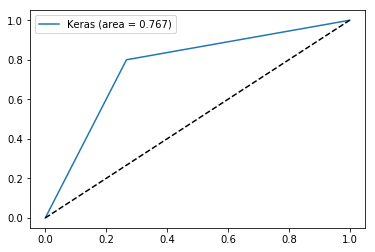

In [48]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [47]:
print(autoencoder_classify.layers)

[<keras.engine.input_layer.InputLayer object at 0x7fce94187be0>, <keras.layers.core.Dense object at 0x7fce94187c18>, <keras.layers.core.Dense object at 0x7fce94187898>, <keras.layers.core.Dense object at 0x7fce82fa0198>]


In [ ]:
autoencoder_recon.layers[1].get_weights()

In [ ]:
autoencoder_classify.layers[-1].get_weights()

Text(0.5,1,'Weights Colormap - 1')

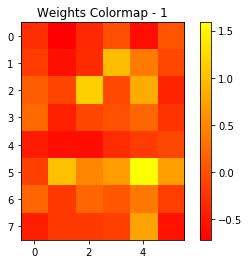

In [50]:
import matplotlib.pyplot as plt
weight, bias = autoencoder_recon.layers[1].get_weights()

plt.imshow(weight, cmap=plt.cm.autumn)
plt.colorbar()
plt.title('Weights Colormap - 1')

([<matplotlib.axis.XTick at 0x7fce8033b198>,
 <a list of 8 Text xticklabel objects>)

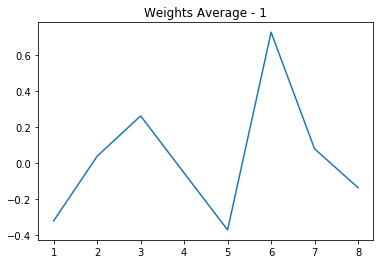

In [52]:
weight_avg = np.average(weight, axis=1)
plt.plot(range(1,9), weight_avg)
plt.title('Weights Average - 1')
plt.xticks(range(1,9))

In [ ]:
df_weight = pd.DataFrame(weight, 
                         columns=['Feature 1','Feature 2','Feature 3', 'Feature 4',
                                 'Feature 5','Feature 6', 'Feature 7'])

df_weight.to_csv("./Weights_sigmoid_1.csv")

In [40]:
decoded_all = autoencoder_recon.predict(x_train)
print(decoded_all)
print(x_train)

[[0.08309639 0.2017416  0.53755784 ... 0.26892006 0.13284165 0.7969153 ]
 [0.089535   0.2132976  0.7834557  ... 0.12539375 0.05533299 0.41297263]
 [0.12417826 0.26960486 0.73942655 ... 0.1593855  0.07446209 0.4347534 ]
 ...
 [0.40076244 0.58103806 0.53181195 ... 0.35224992 0.2124205  0.46843272]
 [0.2481029  0.45457193 0.44092247 ... 0.34503597 0.19681504 0.62167406]
 [0.4122715  0.61372685 0.33915403 ... 0.44327825 0.2911452  0.5968534 ]]
      Contrast  Dissimilarity   Entropy  SumAverage  AutoCorrelation  \
0     0.060793       0.191241  0.508526    0.835470         0.747732   
1     0.078852       0.185523  0.771363    0.424021         0.387763   
2     0.166583       0.338598  0.671784    0.514270         0.369265   
3     0.134599       0.289457  0.800151    0.421111         0.314318   
4     0.163204       0.316215  0.858170    0.362923         0.275476   
5     0.159482       0.294970  0.833486    0.319728         0.263842   
6     0.142493       0.271786  0.835539    0.320574 